### Heteroskedastic noise BNN_LV with PYMC3
LV not explicitly included in pymc3 but in BNN_LV backend

Samples saved out as `hsc_samples_pymc3.npy`

In [1]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')
from utils.data_gen import sample_gaussian_mixture, generate_regression_outputs

In [3]:
import wandb
import pymc3 as pm
import theano.tensor as tt

In [4]:
from IPython.core.debugger import set_trace

# Helper Functions

In [5]:
def myshape(x):
  if((type(x) is np.numpy_boxes.ArrayBox) | (type(x) is numpy.ndarray)):
    return x.shape
  else:
    return x.tag.test_value.shape

In [6]:
# https://github.com/Theano/Theano/pull/3769/files#diff-73defb19c53e8c96044c9d15c8a9d064
# https://stackoverflow.com/questions/38929531/numpy-reshape-array-along-a-specified-axis

import theano
def ttmatmul(a, b):
    """
    Computes the matrix multiplication two tensor variables.
    If any operands are scalar an error is raised.
    If number of dimensions do not match and one operand is a vector, the vector
    is promoted to a matrix before applying operation.
        Note: As the exact shape of the operands cannot be determined at
        compilation time, it is not possible to infer whether the vector should
        be treated as a row- or column vector. Therefore _column_ vectors will
        be assumed, if any inference must be made. such promoted vector will
        have shape = [1, m] as is the default transform from 1D array to
        np.matrix in the numpy library. *note that this is not strictly
        compliant with PEP 465*. Therefore the user must take care to correctly
        transpose the vector if a row vector was intended.
    For two matrices, this is equivalent to matrix multiplication.
    For two vectors, this is the inner product.
    If any operand has more than 2 dimensions, this is a batched matrix
    multiplication:
        The matrix multiplication is performed with the assumption, that the
        operands are stacks of matrices with the matrix residing in the last 2
        dimensions. (remember that a vector is promoted to matrix before this
        step is reached)
        The stacks do not have to have same number of dimensions, the stack with
        the least number dimensions will be broadcast onto the other. This
        corresponds to repeating the stack such that the resulting promoted
        stack matches the other:
            A.ndim = 3, B.ndim=4
            B.shape[0] = 3
            A -> Ap: [A, A, A]
            Ap.ndim = 4
            result: matmult(Ap, B)
        The batching will the be performed over the first n-2 dimensions which
        therefore must match:
            Ap.shape[:-2] == B.shape[:-2]
        To perform the matrix multiplication the last dimension of the first
        operand must match the second to last operand of the second operand:
            Ap.shape[-1] == B.shape[-2]
        The result then has the shape:
            B.shape[:-2] + B[-2] + A[-1]
    """
    nd1, nd2 = a.ndim, b.ndim

    # According to PEP 465 matmul should *not* work with scalars
    if nd1 == 0 or nd2 == 0:
        raise ValueError("Scalar operands are not allowed, use '*' instead")

    # If both operands have ndim < 2 this a simple dot operation
    # promotion of 1d vectors to 2d matrix should be handled by dot()
    if nd1 <= 2 and nd2 <= 2:
        return tt.dot(a, b)

    # if any operand have ndim > 2 this is a batched matrix multiplication.

    # do vector promotion
    if a.ndim == 1:
        a = a.reshape([a.shape[0], 1], 2)

    if b.ndim == 1:
        b = b.reshape([b.shape[0], 1], 2)

    # if the stacks are not aligned, use scan to iterate over first dimension
    # of largest operand and call recursively until a and b has same ndim
    if nd1 != nd2:
        if a.ndim > b.ndim:
            result, updates = theano.scan(
                fn=lambda a_sub_tensor, _b:
                ttmatmul(a_sub_tensor, _b),
                outputs_info=None,
                sequences=[a],
                non_sequences=[b])
            return result

        if a.ndim < b.ndim:
            result, updates = theano.scan(
                fn=lambda b_sub_tensor, _a:
                ttmatmul(_a, b_sub_tensor),
                outputs_info=None,
                sequences=[b],
                non_sequences=[a])
            return result

    # If this code is reached operands have same number of dimensions
    # shape of a and b must be the same except for the last 2 axes which must
    # be compatible with a matrix multiplication:
    #   a: ND (..., dim1, dim2)
    #   b: ND (..., dim2, dim3)

    # for ndim 3 there exists a method we can use without modification
    if nd1 == 3:
        return tt.batched_dot(a, b)

    # for ndim > 3 we flatten all but last 2 dimensions such that the new
    # operands have ndim == 3

    _a = a.reshape([-1, a.shape[-2], a.shape[-1]], 3)
    _b = b.reshape([-1, b.shape[-2], b.shape[-1]], 3)
    out = tt.batched_dot(_a, _b)
    return out.reshape(concatenate([a.shape[:-1], [b.shape[-1]]]), a.ndim)


In [7]:
"""
Implementations of Bayesian models.
For neural networks, we describe the dimensions
with the following conventions, unless otherwise noted:
- The input X is generally a dataset with N rows and M features.
  In some cases, we may have a "stack" of R datasets
  (i.e. X may be a R-by-N-by-M tensor instead of the usual N-by-M matrix)
  but this case is not supported by our initial implementations.
- The output Y is generally an N-by-K matrix (for a K-output model)
  but may also be R-by-N-by-K, analogously with the input X.
- The weights W of a single neural network are stored
  as a 1-by-D matrix (for a network with D weights).
  When representing the weights of a set of S models
  (e.g. mutiple samples from a posterior), the weights
  may be stored in an S-by-D matrix. (Additionally,
  our implementation has an internal representation
  that uses a list of weights for each layer, but
  that version need not be exposed to the user.)
- In a latent variable model, the X and Y inputs follow the same
  conventions as above, but L latent features of Gaussian noise
  are appeneded to the input X to form an augmented input X'.
  Typically there is a single latent variable (i.e. L=1),
  but we have made our implementation flexible so that we can
  exeperiment with multiple latent variables.
  Additionally, Gaussian noise is added to each of the output Y
  (potentially with a different variance for each of the K outputs),
  to form a pertured output Y'.
In summary:
- R: number of "stacked" datasets for X and Y (and X' and Y').
- N: number of data points in X and Y (and X' and Y').
- M: number of features in X.
- K: number of outputs in Y.
- S: number of different models in W.
- D: number of weights in each model.
- L: number of latent noise inputs.
"""


from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam

class BNN:
    """
    A nerual network with M inputs and K outputs with D weights.
    The weights are represented as an S-by-D matrix,
    where D is the total number of weights in the network
    and S is typically 1 but can be an abitrary number of models
    (e.g. when doing a forward pass on a family of models 
    sampled from a posterion during Bayesian modeling).
    """

    def __init__(self, architecture, seed = None, weights = None):
        
        # Layer Assertions
        assert len(architecture['biases']) == len(architecture['activations']), "Error: Mismatch in layer dimensions - biases vs activations"
        assert (len(architecture['biases'])-1) == len(architecture['hidden_layers']), "Error: Mismatch in layer dimensions - must be 1 fewer hidden layer than biases/activations"
        for bias in architecture['biases']:
            assert bias == bool or bias == 1 or bias == 0, "Error: biases must be bool or int[0,1]"
        for act in architecture['activations']:
            assert act in ['relu', 'linear'], "Error: Only 'relu' and 'linear' activations have been implemented"

        # Combine output and hidden layers together to match N weight layers
        all_layers = architecture['hidden_layers'].copy()
        all_layers.append(architecture['output_n'])

        self.layers = {'input_n' : architecture['input_n'],
                       'output_n' : architecture['output_n'],
                       'hidden_layers_shape' : architecture['hidden_layers'],
                       'all_layers_shape' : all_layers,
                       'biases' : architecture['biases'],
                       'activations' : architecture['activations']}   
        self._D, self._layers_D = self._calculate_network_size()
        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))
        
        self.seed = seed
        self.random = np.random.RandomState(seed)

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            assert type(weights) == np.ndarray, "Error: Weights must be a numpy array"
            assert len(myshape(weights)) == 2, "Error: Weights must be specified as a 2D numpy array"
            assert myshape(weights)[1] == self.D, f"Error: Weight dimensions must match the shape specified in the architecture ((1,{self.D}))"
            self.weights = weights

    @property
    def M(self):
        """ Input dimensions. """
        return self.layers['input_n']

    @property
    def K(self):
        """ Output dimensions. """
        return self.layers['output_n']

    @property
    def D(self):
        """ Total number of weights. """
        return self._D

    @property
    def S(self):
        """ Number of different models for which the weights are stored. """
        return myshape(self.weights)[0]

    @property
    def H(self):
        """ Number of hidden layers (not counting input or output). """
        return len(self.layers['hidden_layers_shape'])

    def _calculate_network_size(self):
        '''
        Calculate the number of weights required to represent the specific architecture
        '''
        D = 0
        layers_D = []
        for i in range(len(self.layers['hidden_layers_shape'])):
            # First layer so use input nodes
            if i == 0:
                D += (self.layers['input_n'] * self.layers['hidden_layers_shape'][i])
            else:
                D += self.layers['hidden_layers_shape'][i-1] * self.layers['hidden_layers_shape'][i]
            if self.layers['biases'][i]:
                D += self.layers['hidden_layers_shape'][i]
            layers_D.append(D - int(np.sum(layers_D)))
        # Final output layer
        if len(self.layers['hidden_layers_shape'])>0:
            D += self.layers['hidden_layers_shape'][-1] * self.layers['output_n']
        else:  # Special case if there are no hidden layers:
            D += self.layers['input_n'] * self.layers['output_n']
        if self.layers['biases'][-1]:
            D += self.layers['output_n']
        layers_D.append(D - int(np.sum(layers_D)))

        return D, layers_D

    def stack_weights(self, W_layers):
        """
        Takes a list of (S-by-)IN-by-OUT tensors
        storing the weights for each layer in a model
        (or in each model from a set of S models)
        and returns an S-by-D matrix of the weights
        for the whole network (where S is 1 if there is only 1 model).
        IN and OUT are the number of input and output nodes
        for the given layer.
        """
        
        # Store results:
        W = []

        # Check numer of layers:
        n_layers = len(self.layers['all_layers_shape'])
        assert len(W_layers)==n_layers, f"Received {len(W_layers)} layers but expected {n_layers}."
        
        # Get dimensions:
        S = myshape(W_layers[0])[0] if len(myshape(W_layers[0]))==3 else 1
        
        # Loop through layers:
        for i,W_layer in enumerate(W_layers):
            
            # Get expected layer sizes:
            if i==0:
                source_size = self.layers['input_n']
            else:
                source_size = self.layers['all_layers_shape'][i-1]
            source_size += self.layers['biases'][i]
            target_size = self.layers['all_layers_shape'][i]
            
            # Check dimensions:
            if len(myshape(W_layer))==2:
                W_layer = W_layer.reshape((1,*myshape(W_layer)))
            elif len(myshape(W_layer))==3:
                assert myshape(W_layer)[0]==S, f"[layer {i+1}] Encounted set of {myshape(W_layer)[0]} weights but expected {S}."
            else:
                raise ValueError("W should be (S-by-)IN-by-OUT, i.e. (3 or) 2 dimenisions.")
            assert myshape(W_layer)[-2]==source_size, f"[layer {i+1}] Rows ({myshape(W_layer)[-2]}) should correspond to input nodes ({source_size})."
            assert myshape(W_layer)[-1]==target_size, f"[layer {i+1}] Columns ({myshape(W_layer)[-1]}) should correspond to output nodes ({target_size})."
            
            # Reshape and add to stack:
            W_layer = W_layer.reshape((S,source_size*target_size))
            W.append(W_layer)
        
        W = np.hstack(W)
        assert myshape(W) == (S,self.D), f"Found {myshape(W)[1]} weights but expected {self.D}."
        
        return W

    def unstack_weights(self, W):
        """
        Creates a list of the weights for each layer.
        W may be a row-vector of weights, or a matrix
        where each row corresponds to a different
        specification of the model (e.g. we may have S
        sets of weights, representing S different BNNs,
        given as a S-by-D matrix.)
        """
        
        if len(myshape(W))==1:
            W = W.reshape((1,-1))
        elif len(myshape(W))==2:
            assert myshape(W)[1] == self.D, "Second dimension must match number of weights."
        else:
            raise ValueError("W should be S-by-D or 1-by-D (i.e. max 2 dimenisions).")
        
        # Determine how many sets of weights we have:
        S = myshape(W)[0]
            
        # Get sizes of layers:
        source_sizes = [self.layers['input_n']] + self.layers['all_layers_shape'][:-1]
        target_sizes = self.layers['all_layers_shape']
        for i,bias in enumerate(self.layers['biases']):
            source_sizes[i] += bias  # 0 or 1
            
        # Loop through layers:
        W_layers = []
        cursor = 0  # Keep track row of W.
        for source_size, target_size in zip(source_sizes,target_sizes):
            # Get the chunk of weights corresponding to this layer:
            W_layer = W[ :, cursor:(cursor+source_size*target_size) ]
            # Reshape the chunk to stack of matrices (i.e. a 3d tensor)
            # Where each matrix has rows corresponding to source nodes
            # and columns corresponding to target nodes:
            W_layer = W_layer.reshape((S, source_size, target_size))
            # Add tensor to list:
            W_layers.append(W_layer)
            # Update cursor:
            cursor += source_size*target_size
            
        return W_layers

    def set_weights(self, weights):
        '''
        Manually set the weights of the Neural Network
        '''
        if isinstance(weights, list):
            weights = self.stack_weights(weights)
        assert type(weights) == np.ndarray, "Error: Weights must be a numpy array"
        assert len(myshape(weights)) == 2, "Error: Weights must be specified as a 2D numpy array"
        assert myshape(weights)[1] == self.D, f"Error: Weight dimensions must match the shape specified in the architecture (num_weights={self.D})"
        self.weights = weights
        return

    def get_weights(self):
        '''
        Simple wrapper to return weights
        '''
        return self.weights

    @staticmethod
    def relu(x):
      if((type(x) is np.numpy_boxes.ArrayBox) | (type(x) is numpy.ndarray)):
        return np.maximum(np.zeros(shape=myshape(x)), x)
      else:
        return pm.math.maximum(np.zeros(x.tag.test_value.shape), x)

    @staticmethod
    def identity(x):
        return x

    def fit(self, X, Y, step_size=0.01, max_iteration=5000, check_point=100, regularization_coef=None):
        '''
        '''
        # Check X dimensions:
        if len(myshape(X)) < 2:
            raise ValueError(f"X should be (at least) 2 dimensional; myshape(X)={myshape(X)}.")
        assert myshape(X)[-1]==self.M, f"Last dimenion of X is {myshape(X)[-1]} but should correspond to {self.M} inputs (i.e. features)"
        # Check Y dimensions:
        if len(myshape(Y)) < 2:
            raise ValueError(f"Y should be (at least) 2 dimensional; myshape(Y)={myshape(Y)}.")
        assert myshape(Y)[-1]==self.K, f"Last dimenion of Y is {myshape(Y)[-1]} but should correspond to {self.K} output"
        # Get number of "stacks" of datasets (i.e. the arbitrary dimensions before N and M,K):
        assert myshape(X)[:-1] ==  myshape(Y)[:-1], f"Besides the final dimension (M,K), the dimensions of X {myshape(X)} and Y {myshape(Y)} should match."
        N = myshape(X)[-2]  # Number of rows.
        R = myshape(X)[:-2]  # Arbitrary dimensions that precede the number of rows (N) and features (M).
        # Raise implementation error if there is more than a single 2D dataset:
        if len(R)>0:
            raise NotImplementedError(f"Current implementation does not support datasets of aritrary dimension, must be N-by-M; myshape(X)={myshape(X)}.")
        
        def objective(W, t):
            ''' Callbacks for each optimization step '''
            squared_error = np.linalg.norm(Y - self.forward(X, weights=W), axis=-1)**2
            if regularization_coef is None:
                mse = np.mean(squared_error, axis=-1)
                return mse
            else:
                mse = np.mean(squared_error, axis=-1) + regularization_coef * np.linalg.norm(W, axis=-1)
                return mse

        obj_gradient = grad(objective)

        def _call_back(weights, iteration, g):
            ''' Callbacks for each optimization step '''
            objective_val = objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective_val))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective_val, np.linalg.norm(obj_gradient(weights, iteration))))

    
        # Run the training method
        adam(obj_gradient, self.weights, step_size=step_size, num_iters=max_iteration, callback=_call_back)
        optimum_index = np.argmin(self.objective_trace[1:])
        self.weights = self.weight_trace[1:][optimum_index].reshape((1,-1))
        return

    def forward(self, X, weights=None):
        '''
        Perform a forward pass through the network from input to output.
        Requires the last dimension of X to be the number of inputs (i.e. features).
        X is generally expected by be an N-by-M matrix, but may in fact have
        an arbitrary dimensions instead of N (as long as M is the last dimension).
        The K outputs will be along the last dimension (with prior dimensions
        matching those of X, i.e. the typical output will be an N-by-K matrix).
        '''
        # Check X dimensions:
        if len(myshape(X)) < 2:
            raise ValueError(f"X should be (at least) 2 dimensional; myshape(X)={myshape(X)}.")
        M = myshape(X)[-1]  # Number of features (final dimension).
        N = myshape(X)[-2]  # Number of rows (dimension before last).
        R = myshape(X)[:-2]  # Arbitrary dimensions that precede the number of rows (N) and features (M).
        assert myshape(X)[-1]==self.M, f"Last dimenion of X is {myshape(X)[-1]} but should correspond to {self.M} inputs (i.e. features)"
        # Raise implementation error if there is more than a single 2D dataset:
        if len(R)>0:
            raise NotImplementedError(f"Current implementation does not support datasets of aritrary dimension, must be N-by-M; myshape(X)={myshape(X)}.")
        
        # Get weights for each layer (as tensors):
        weights = self.weights if weights is None else weights
        W_layers = self.unstack_weights(W=weights)

        # Determine shape of output:
        S = myshape(weights)[0]  # Number of different models represented.
        Y_shape = tuple([ S, *myshape(X)[:-1], self.layers['output_n'] ])  # Determine shape of output.

        # Copy data to values to iterate through the network
        values_in = X.copy()

        # Loop through layers:
        #   Reminder: W_layer is an S-by-IN-by-OUT tensor of the weights for S models,
        #   with layer inputs on the rows and layer outputs on the columns.
        for i, weights in enumerate(W_layers):
            
            # If there is a bias, postpend a column of ones to each matrix:
            bias = self.layers['biases'][i]
            if bias==1:
                bias_features = np.ones((*myshape(values_in)[:-1],1))
                if((type(weights) is np.numpy_boxes.ArrayBox) | (type(weights) is numpy.ndarray)):
                  values_in = np.append(values_in,bias_features,axis=-1)
                else:
                  values_in = tt.concatenate([values_in,bias_features],axis=-1)
                # values_in = numpy.concatenate([values_in,bias_features], axis=len(myshape(values_in))-1) ##edited

            # Calculate pre-activation values:
            # set_trace()
            if((type(weights) is np.numpy_boxes.ArrayBox) | (type(weights) is numpy.ndarray)):
              values_pre = np.matmul( values_in, weights )
            else:
              values_pre = ttmatmul(values_in, weights)
            

            # Apply activation fucntion:
            if self.layers['activations'][i] == 'relu':
                values_out = self.relu(values_pre)
            elif self.layers['activations'][i] == 'linear':
                values_out = self.identity(values_pre)
            else:
                raise ValueError(f"Error: Unexpected activation type - {self.layers['activations'][i]}")

            # Pass output values as input to next layer:
            values_in = values_out

        Y = values_out.reshape((Y_shape))

        # Special case: If input was 2D and there is only one set of weights
        # return a 2D output instead of 3D output with a first dimension of 1:
        if (S==1) and (len(myshape(Y))==3) and (myshape(Y)[0]==1):
            S,N,K = myshape(Y)
            Y = Y.reshape((N,K))  # Drop the first dimension where S=1.
        
        return Y


class BNN_LV(BNN):
    """
    Implementation of Bayesian Neural Network with Latent Variables
    https://arxiv.org/pdf/1605.07127.pdf  Section 2.2.
    """

    def __init__(self, architecture, seed = None, weights = None):
        """
        Initialize a BNN with Latent Variable:
            Given an input X with N rows and M features,
            augment X by appeend L gaussian noise features (forming a modfied input X')
            and perturb Y by adding gaussian noise (forming a modified output Y').
            All noise has mean zero, and the standard devation is a hyperparameter:
            Each of the L latent variable inputs has its own standard deviation (gamma)
            and the noise on each of the K outputs has its own standard deviation (sigma).
        Uses the same architecture as the BNN superclass, but expects additional keys:
            gamma : list of L standard deviations for the latent variable inputs.
            sigma : list of K standard deviations for the additive output noises.
        """
        # Add a noise input.
        architecture = architecture.copy()
        assert 'input_n' in architecture.keys()  # Will be augmented by L below.
        # Get standard deviation of noise:
        if 'gamma' not in architecture:
            raise KeyError("Make sure achitecture includes 'gamma' (list of standard deviations for the L latent variable inputs).")
        self.gamma = architecture['gamma']  # List.
        if 'sigma' not in architecture:
            raise KeyError("Make sure achitecture includes 'sigma' (list of standard deviations for the K additive output noises).")
        self.sigma = architecture['sigma']  # List.
        # Check dimensions:
        self.gamma = np.array([self.gamma]).flatten()  # Coerce list to numpy array.
        self.sigma = np.array([self.sigma]).flatten()  # Coerce list to numpy array.
        if len(self.sigma) != architecture['output_n']:
            raise ValueError(f"The dimension of 'sigma' ({len(self.sigma)}) should match the dimension of the output ({architecture['output_n']}).")
        # Adjust input size by number of latent variables:
        self.L = len(self.gamma)
        architecture['input_n'] += self.L
        # Build a neural_network:
        super().__init__(architecture, seed=seed, weights=weights)
        # Keep track of latest noise variables:
        self.last_input_noise = None
        self.last_output_noise = None
        # Store addition state variables:
        self.fitting = False  # Flag for handing recursive calls to `fit` (generally False).
    
    def add_input_noise(self,X, input_noise='auto'):
        """
        Add a feature of input noise drawn from a Gaussian distribution
        with mean 0 and the standard deviation.
        X:
            The input to augment with latent features.
        input_noise:
            'auto' : Stochasticify is added automatically according to the BNN_LV's parameters.
            'zero' : No noise is added (i.e. adds columns of zeros instead of noise features).
            [tensor-like object] : Adds user-specified noise.
        """
        Z_shape = tuple((*myshape(X)[:-1],self.L))
        if input_noise=='auto':
            Z = self.random.normal(loc=0, scale=self.gamma, size=Z_shape)
        elif input_noise=='zero':
            Z = np.zeros(Z_shape)
        else:
            try:
                Z = input_noise
                assert myshape(Z) == Z_shape
            except:
                raise ValueError(f"Expected an tensor-like object with shape {Z_shape} .")
        self.last_input_noise = Z  # Store last noise for access during training.
        
        if((type(Z) is np.numpy_boxes.ArrayBox) | (type(Z) is numpy.ndarray)):
            X_ = np.append(X,Z, axis=-1)
        else:
            X_ = tt.concatenate([X,Z], axis=-1)
        
        return X_
    
    def add_output_noise(self,Y_, output_noise='auto'):
        """
        Corrupt output with additive noise drawn from a Gaussian distribution
        with mean 0 and a standard deviation specified for each dimension of the output.
        Y_:
            The output to perturb with additive noise.
        output_noise:
            'auto' : Stochasticify is added automatically according to the BNN_LV's parameters.
            'zero' : No noise is added (i.e. leaves the output unchanged).
            [tensor-like object] : Adds user-specified noise.
        """
        Eps_shape = myshape(Y_)
        if output_noise=='auto':
            Eps = self.random.normal(loc=0, scale=self.sigma, size=Eps_shape)
        elif output_noise=='zero':
            Eps = np.zeros(Eps_shape)
        else:
            try:
                Eps = output_noise
                assert myshape(Eps) == Eps_shape
            except:
                raise ValueError(f"Expected an tensor-like object with shape {Eps_shape} .")
        self.last_output_noise = Eps  # Store last noise for access during training.
        Y = Y_ + Eps
        return Y
        
    def forward(self, X, weights=None, input_noise='auto', output_noise='auto'):
        """
        Perform a forward pass. Noise is added automatically unless specified by the user.
        input_noise:
            Parameter passed to `add_input_noise` (see that function for details).
        output_noise:
            Parameter passed to `add_output_noise` (see that function for details).
        """
        # Add input noise (extra feature):
        # Note: During gradient descent (i.e. when `fitting` flag is True),
        #       this step is skipped because noise was already added by `fit` method.
        if not self.fitting:
            X_ = self.add_input_noise(X, input_noise=input_noise)
        else:
            # During gradient descent (i.e. when `fitting` flag is True),
            # don't augment X because that was already handled by `fit` method.
            X_ = X

        # Perform forward pass through regular BNN:
        Y_ = super().forward(X_, weights=weights)

        # Add output noise (additive):
        if not self.fitting:
            Y = self.add_output_noise(Y_, output_noise=output_noise)
        else:
            # During gradient descent (i.e. when `fitting` flag is True),
            # don't augment Y because that was already handled by `fit` method.
            Y = Y_
        return Y

    def fit(self, X, Y, *args, **kwargs):
        """
        Fit the non-noisy verion of the neural net using gradient descent.
        (This is a non-bayesian approach, but useful for finding initialization weights).
        """
        # Prepare X and Y:
        X_ = self.add_input_noise(X, input_noise='zero')
        Y_ = self.add_output_noise(Y, output_noise='zero')

        self.fitting = True  # Put BNN LV in fit mode so that it stops adding columns to X.
        super().fit(X=X_, Y=Y_, *args, **kwargs)
        self.fitting = False  # Restore normal state.
        return

# Heteroskedastic Noise

In [16]:
y_hsc, X_hsc = generate_regression_outputs(type='hsc')

In [17]:
# Parameters
gamma = 1
sigma = 1

architecture = {'input_n':1, 
             'output_n':1, 
             'hidden_layers':[20,20],
             'biases' : [1,1,1],
             'activations' : ['relu', 'relu', 'linear'],
             'gamma':[gamma],
             'sigma':[sigma]}
bnn_lv = BNN_LV(architecture=architecture)

bnn_lv.fit(X_hsc, y_hsc, step_size=0.01, max_iteration=5000, check_point=500, regularization_coef=None)

Iteration 0 lower bound 830.7720418664411; gradient mag: 3027.7862230010514
Iteration 500 lower bound 3.4968032740529846; gradient mag: 0.28603844196944644
Iteration 1000 lower bound 3.435797110257811; gradient mag: 0.3212303132069177
Iteration 1500 lower bound 3.3977157105996763; gradient mag: 7.9573543146554915
Iteration 2000 lower bound 3.3646174817081254; gradient mag: 6.676509636822481
Iteration 2500 lower bound 3.3513498668469466; gradient mag: 6.368896225070822
Iteration 3000 lower bound 3.3388595248726425; gradient mag: 3.6183217068257116
Iteration 3500 lower bound 3.3380750000047503; gradient mag: 5.747355714874942
Iteration 4000 lower bound 3.3460625531049955; gradient mag: 11.8995465194356
Iteration 4500 lower bound 3.333582614195446; gradient mag: 5.812873884835474


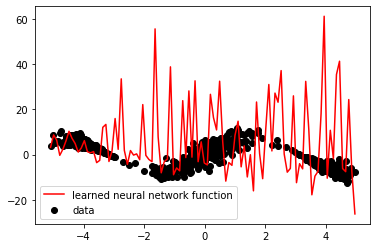

In [18]:
x_test = np.linspace(min(X_hsc), max(X_hsc), 100).reshape((1, -1))

#predict on the test x-values
y_test_pred = bnn_lv.forward(x_test.reshape(100,1))

#visualize the function learned by the neural network
plt.scatter(X_hsc.flatten(), y_hsc.flatten(), color='black', label='data')
plt.plot(x_test.flatten(), y_test_pred.flatten(), color='red', label='learned neural network function')
plt.legend(loc='best')
plt.show()

In [22]:
def plot95ci(nn, X, trace_w):
    # Make predicitons:
    X = np.array(X).flatten().reshape(-1,1)
    N = X.shape[0]  # Number of data points.
    S = trace_w.shape[0]  # Number of models.
    D = trace_w.shape[-1]  # Number of weights.
    W = trace_w.reshape(S,D)  # Weights of S models.
    y_preds = nn.forward(X, W).reshape(S,N)  # Preds for S models.
    # Calculate percentiles
    y_lower = np.percentile(y_preds, q=2.5, axis=0).flatten()
    y_upper = np.percentile(y_preds, q=97.5, axis=0).flatten()
    y_med = np.percentile(y_preds, q=50, axis=0).flatten()
    x_vals = X.flatten()
    # Plot with confidence
    fig, ax = plt.subplots(1,1,figsize=(14,7))
    data = pd.DataFrame({'x_vals':x_vals,'y_lower':y_lower,'y_med':y_med,'y_upper':y_upper})
    ax.plot('x_vals', 'y_upper', data=data, label="Upper 95%", color='grey')
    ax.plot('x_vals', 'y_med', data=data, label="Median Prediction", color='black')
    ax.plot('x_vals', 'y_lower', data=data, label="Lower 95%", color='grey')
    #ax.fill_between('x_vals', 'y_lower', 'y_upper', data=data, alpha=0.4, color='r', label="95% Predictive Interval")
    ax.set_title("Bayesian Neural Net Predictions with 95% CI")
    ax.set_xlabel("X Test")
    ax.set_ylabel("Y Predicted")
    #ax.legend()
    # plt.ylim([-8,4])
    # plt.show()
    return fig, ax

def wb_scatter(nn, X, trace_w):
    X = np.array(X).flatten().reshape(-1,1)
    S = trace_w.shape[0]
    D = trace_w.shape[-1]
    W = trace_w.reshape(S,D)
    y_pred = nn.forward(X, W)
    x_vals = np.tile(X, reps=(S,1,1))
    assert y_pred.shape == x_vals.shape
    x_vals = x_vals.flatten()
    y_pred = y_pred.flatten()
    # Build W&B table and plot:
    data = [[x, y] for (x, y) in zip(x_vals.flatten(), y_pred.flatten())]
    table = wandb.Table(data=data, columns = ["x_test", "y_pred"])
    plot = wandb.plot.scatter(table, "x_test", "y_pred")
    wandb.log({"post_pred_scatter" : plot})
    print(f"Callback: Built plot with {S} samples.")

def build_wb_callback(nn, X, iters_log=25, iters_plot=250):
    it = 0
    X = np.array(X).flatten().reshape(-1,1)
    def wb_callback(trace, draw):
        # Get iteration:
        nonlocal it
        it = it + 1
        if it % iters_log == 0:
            # Log iteration:
            #wandb.log({'iteration' : it}, step=it)
            # Log stats:
            wandb.log(draw.stats[-1], step=it)
        if it % iters_plot == 0:
            # Make plot (optional):
            trace_w = trace.get_values('w')
            fig, ax = plot95ci(nn, X, trace_w)
            wandb.log({"post_pred_95ci": fig}, step=it)
        return
    return wb_callback


In [24]:
# %debug

p_mu = 0
p_sigma = 5
l_sigma = 0.25
lv_gamma = 1

my_tune = 2000
my_draws = 1500
my_target_accept = 0.90
my_max_treedepth = None


nn = bnn_lv
# X_test = np.linspace(-6,6,100)
X_test = np.linspace(min(X_hsc), max(X_hsc), 100).reshape((1, -1))

# Initialize a W&B run:
wandb.init(
    entity    = 'gpestre',  # Don't change this.
    project   = 'am207',  # Don't change this.
    group     = 'pymc3_hsc',
    name      = 'first_hsc_attempt',
    notes     = 'Initial test with init weights',
    config    = {
        # Manually archive info about network and priors.
        'architecture' : architecture,
        'p_mu' : p_mu,
        'p_sigma' : p_sigma,
        'l_sigma' : l_sigma,
        'lv_gamma' : lv_gamma,
        'tune' : my_tune,
        'draws' : my_draws,
    },
)

wb_callback = build_wb_callback(nn=bnn_lv, X=X_hsc, iters_log=50, iters_plot=250)

#################################################################################
with pm.Model() as pm_model:
    
    w_prior = pm.Normal('w', mu=p_mu, sigma=p_sigma, shape=bnn_lv.weights.shape)  
#     lv_prior = pm.Normal('z', mu=0, sigma=lv_gamma, shape=(X_hsc.shape[0],1))
        
#     y = pm.Normal('y', mu=bnn_lv.forward(X=X_hsc, input_noise = lv_prior, weights=w_prior),
#                   sigma = l_sigma, observed=y_hsc)
#     trace = pm.sample(tune=my_tune, draws=my_draws, start = {'w': bnn_lv.weights}, target_accept=my_target_accept,
#                       max_treedepth = my_max_treedepth, callback=wb_callback)
    
    y = pm.Normal('y', mu=bnn_lv.forward(X=X_hsc, weights=w_prior),
                  sigma = l_sigma, observed=y_hsc)
    
    trace = pm.sample(tune=my_tune, draws=my_draws, start = {'w': bnn_lv.weights},
                      target_accept=my_target_accept, callback=wb_callback)

    
    
#################################################################################

wb_filepath = f'temp_pymc3_trace_{wandb.run.id}.npy'
np.save(wb_filepath, trace['w'])
wandb.save(wb_filepath)

wb_scatter(nn=nn, X=X_test, trace_w=trace['w'])

wandb.finish()


tune,True
diverging,False
perf_counter_diff,54.05161
process_time_diff,93.17458
perf_counter_start,489.35498
depth,15
mean_tree_accept,0.58991
energy_error,0.83994
energy,2657.77573
tree_size,32767
max_energy_error,2.25119


tune,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
diverging,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perf_counter_diff,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
process_time_diff,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
perf_counter_start,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄█
depth,▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅█
mean_tree_accept,▁█▇█▇██▆▇█▇██▇▇▇██▇████▇▇██▇█▇▇█▅
energy_error,▃▄▄▃▄▃▃▅▄▃▅▃▃▂▃▃▂▂▃▃▃▃▁▄▄▃▃▅▁▅▅▁█
energy,█▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
tree_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
max_energy_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


/Users/nikhilvanderklaauw/opt/anaconda3/envs/datasci/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning:

In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 2_000 tune and 1_500 draw iterations (8_000 + 6_000 draws total) took 5157 seconds.
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '79541' (I am process '77752')
The acceptance probability does not match the target. It is 0.9786898983230963, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.7841081020498158, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.7960235853823615, but should be close to 0.9. Try to increase the number of tuning steps.
The chai

Callback: Built plot with 6000 samples.


tune,False
diverging,False
perf_counter_diff,0.36316
process_time_diff,1.44997
perf_counter_start,6055.24624
depth,10
mean_tree_accept,0.70011
energy_error,1.05004
energy,17631.55532
tree_size,1023
max_energy_error,17.99131


tune,███████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
diverging,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perf_counter_diff,▁▁▅▅▅▅▅▆▅▅▆▅▅▆█▆▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▅▆▆▆▇▆▅▆▂
process_time_diff,▁▁▆▆▇▆▆▇▆▆▇▆▆▇█▇▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▆█▇▇█▇▇▇▃
perf_counter_start,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
depth,▁▁██████████████████████████████████████
mean_tree_accept,▆▅▇▅█▆▂▇█▆▇▅█▄▆█▇▇▇█▅▆▇▅█▇█▁▆█▂▇▇▇█▆█▂▇▂
energy_error,▃▅▄▆▄▅▇▃▄▅▃▆▄▄▅▃▃▄▅▄▄▁▅▄▄▄▄█▅▄▇▅▅▅▁▅▄▁▄█
energy,█▇▇▅▅▅▆▅▃▃▄▃▃▃▂▂▂▄▂▂▃▂▂▂▂▂▂▂▂▂▃▂▃▂▁▂▂▁▁▁
tree_size,▁▁██████████████████████████████████████
max_energy_error,▁▁▁▂▁▁▂▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁█▂▆


In [41]:
np.save('hsc_samples_pymc3.npy', trace['w'])

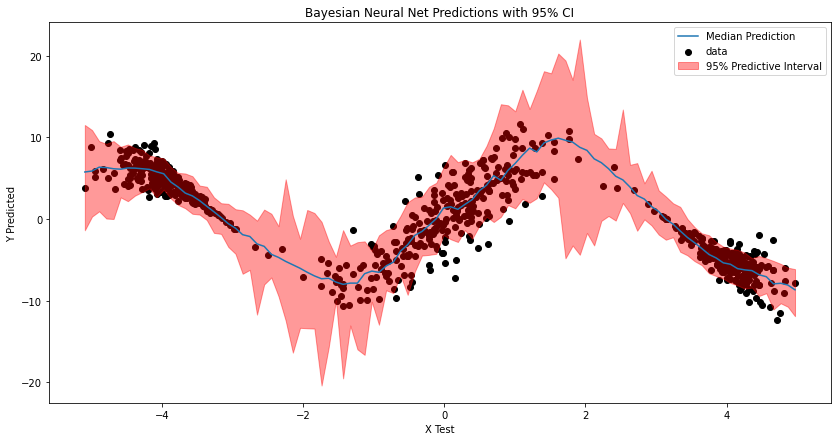

In [31]:
bayesian_lv_weights = trace['w']

# Take 100 random posterior samples
w_random_samples = bayesian_lv_weights[np.random.choice(bayesian_lv_weights.shape[0], 100), :]

y_preds = []

# Loop through the samples of weights
for i in range(w_random_samples.shape[0]):
    # Create the same NN for predictions but with weights from the samples
    w_cur = w_random_samples[i,:]

    mu_pred = bnn_lv.forward(x_test.reshape(-1,1), w_cur)
    y_pred = mu_pred
    y_preds.append(y_pred.reshape(-1))

# Calculate percentiles
y_lower = np.percentile(y_preds, q=2.5, axis=0)
y_upper = np.percentile(y_preds, q=97.5, axis=0)
y_med = np.percentile(y_preds, q=50, axis=0)

# Plot with confidence
plt.figure(figsize=(14,7))
plt.scatter(X_hsc.flatten(), y_hsc.flatten(), color='black', label='data')
plt.plot(x_test.flatten(), y_med, label="Median Prediction")
plt.fill_between(x_test.flatten(), y_lower, y_upper, alpha=0.4, color='r', label="95% Predictive Interval")
plt.title("Bayesian Neural Net Predictions with 95% CI")
plt.xlabel("X Test")
plt.ylabel("Y Predicted")
plt.legend()
# plt.ylim([-8,4])
plt.show()

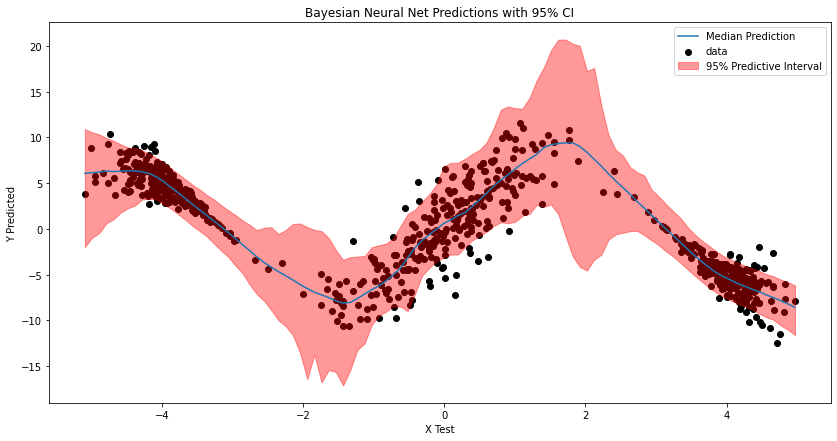

In [37]:
# Using all samples
w_random_samples = trace['w']

y_preds = []

# Loop through the samples of weights
for i in range(w_random_samples.shape[0]):
    # Create the same NN for predictions but with weights from the samples
    w_cur = w_random_samples[i,:]

    mu_pred = bnn_lv.forward(x_test.reshape(-1,1), w_cur)
    y_pred = mu_pred
    y_preds.append(y_pred.reshape(-1))

# Calculate percentiles
y_lower = np.percentile(y_preds, q=2.5, axis=0)
y_upper = np.percentile(y_preds, q=97.5, axis=0)
y_med = np.percentile(y_preds, q=50, axis=0)

# Plot with confidence
plt.figure(figsize=(14,7))
plt.scatter(X_hsc.flatten(), y_hsc.flatten(), color='black', label='data')
plt.plot(x_test.flatten(), y_med, label="Median Prediction")
plt.fill_between(x_test.flatten(), y_lower, y_upper, alpha=0.4, color='r', label="95% Predictive Interval")
plt.title("Bayesian Neural Net Predictions with 95% CI")
plt.xlabel("X Test")
plt.ylabel("Y Predicted")
plt.legend()
# plt.ylim([-8,4])
plt.show()